In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
new_path = '/content/drive/MyDrive/PRIM_HSU'

# Установить новый путь в качестве текущей директории
os.chdir(new_path)

In [3]:
from src.data_processing import HyperspectralImage, PerturbedSVDataPatches, generate_honest_sv_patches
from torch.utils.data import DataLoader
from src.models import Autoencoder
from src.train_utils import train_model
from src.conf import BATCH_SIZE
from src.loss_functions import balance_loss
import matplotlib.pyplot as plt
import torch
from src.metrics import compare_endmembers, compare_abundances
import numpy as np

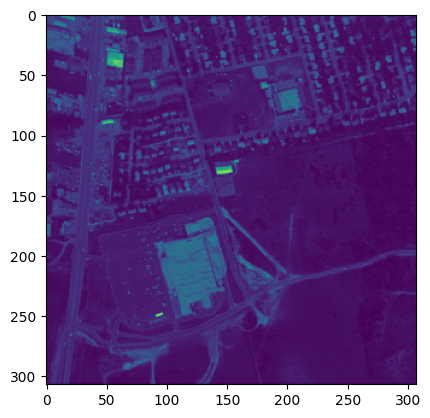

original_image_dataloader torch.Size([10, 162, 40, 40])


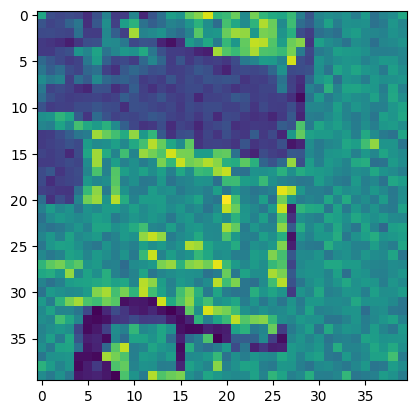

In [4]:
urban = HyperspectralImage(image_path="datasets/urban/Urban.mat",
                           ground_truth_path="datasets/urban/end6_groundTruth.mat",
                           n_bands=162, n_row=307, n_col=307, n_sources=6)

X_1_estim = np.load('results/first_estimation/X_1_estim.npy')
A_1_estim = np.load('results/first_estimation/A_1_estim.npy')
S_1_estim = np.load('results/first_estimation/S_1_estim.npy')

# generate_honest_sv_patches(urban, A_1_estim, S_1_estim)

plt.imshow(urban.X[0])
plt.show()

pertubed_sv_image_dataset = PerturbedSVDataPatches()


pertubed_sv_image_dataloader = DataLoader(dataset=pertubed_sv_image_dataset, batch_size=BATCH_SIZE, shuffle=True)
a = next(iter(pertubed_sv_image_dataloader))
print('original_image_dataloader', a["X"].shape)
plt.imshow(a['X'][0][50])
plt.show()

In [5]:
model = Autoencoder(channel_number=urban.n_bands, source_number=urban.n_sources)
model, loss_train = train_model(model, urban.X,
                                pertubed_sv_image_dataloader,
                                balance_loss, num_epochs=50, n_sources=6, need_plot=True)

Output hidden; open in https://colab.research.google.com to view.

In [6]:
torch.save(model.state_dict(), "results/models_weights/urban_sv_perturbed_honest_patches.pth")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X, A, S = model(torch.Tensor(urban.X[None, :, :, :]).to(device))
X, A, S = X.cpu().detach().numpy()[0], A.cpu().detach().numpy(), S.cpu().detach().numpy()[0]
# Endmembers normalization
for i in range(A.shape[1]):
        M = A[:, i].max().item()
        A[:, i] = A[:, i]/M

print('compare_endmembers', compare_endmembers(urban, A))
plt.figure(figsize=(8,6))
for ii in range(6):
    ax = plt.subplot(2, 3, ii+1)
    ax.plot(A[:,ii])
plt.show()

print('compare_abundances', compare_abundances(urban, S))
plt.figure(figsize=(8,6))
for ii in range(6):
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(S[ii, :, :])
plt.show()

AttributeError: ignored